In [1]:
import pandas as pd
import numpy as np
import json
import nltk
import re
import csv
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import pickle

In [2]:
%matplotlib inline
pd.set_option('display.max_colwidth', 300)
sns.color_palette("rocket")

[(0.20973515, 0.09747934, 0.24238489),
 (0.43860848, 0.12177004, 0.34119475),
 (0.67824099, 0.09192342, 0.3504148),
 (0.8833417, 0.19830556, 0.26014181),
 (0.95381595, 0.46373781, 0.31769923),
 (0.96516917, 0.70776351, 0.5606593)]

In [3]:
input_filename = 'temp/db'
articoli = pd.read_csv(input_filename, sep=";")
articoli['Data'] = articoli['Data'].astype('datetime64[ns]') 
#articoli = articoli.replace(np.nan, '', regex=True)
del(articoli["Unnamed: 0"])

In [4]:
articoli['ID'].count()

12735

In [5]:
articoli.head(1)

,Titolo,Data,Testo,ID,Txt,Anno,Mese,Day,Week,Keywords,Words,ComputedTags,NumberOfTags,People,Tech,Tag,Location,Company,Vertical,Application
0,Numenta Is Imitating Your Brain,2008-07-11,Decent piece in BusinessWeek profiling Jeff Hawkins startup Numenta. Numenta is building artificial intelligence that attempts to replicate the function of the human neocortex to solve hard problems. The software specializes in recognizing patterns within massive streams of data. I am a big fan ...,52360f85d1245da83f1da41ebc3e8449,numenta imitating brain decent piece businessweek profiling jeff hawkins startup numenta numenta building artificial intelligence attempts replicate function human neocortex solve hard problems software specializes recognizing patterns within massive streams data big fan jeff hawkins short plug ...,2008,7,11,28,"jeff, brain, palm, intelligence, tech industry, specializes, decent, secrets, straightforward, inner, recognizing, introduction, streams, replicate, pursue, unlock, fan, neuroscience, plug, attempts, dream, pilot, degree, book, patterns, tech, industry","['brain', 'neuroscience', 'tech', 'tech industry']","Tag: Technology, Vertical: Health & Medicine, Tag: Neuroscience, Tech: Brain Computer Interfaces",4,NaN,Brain Computer Interfaces,"Technology, Neuroscience",NaN,NaN,Health & Medicine,NaN


# 1. Subset (Data, Tech, Appl, Vertical)

In [6]:
df = articoli[['Data', 'Tech', 'Application', 'Vertical']]

#### Remove rows where at least 2 columns are NaN

In [7]:
cols = ['Tech','Application','Vertical']
df = df.dropna(subset=cols, thresh=2).reset_index()

# NaN to empty
df = df.replace(np.nan, '', regex=True)

df.drop(['index'], axis=1, inplace=True)

In [8]:
df

,Data,Tech,Application,Vertical
0,2008-07-11,Brain Computer Interfaces,,Health & Medicine
1,2008-07-16,Brain Computer Interfaces,,Technology
2,2008-07-24,,Bio Engineering,Health & Medicine
3,2008-08-15,"Industrial IoT, Brain Computer Interfaces",,Science
4,2008-09-17,,Bio Engineering,"Food & Beverage, Health & Medicine, Automotive"
...,...,...,...,...
8293,2013-03-07,,Cybersecurity,Energy & Utility
8294,2012-10-01,"Industrial IoT, Connectivity, Mobile",Crowdfunding,Energy & Utility
8295,2011-05-03,,Sharing Economy,Advertising
8296,2010-09-20,Industrial IoT,,Technology


In [9]:
#def OLD explode(df):
#    data_tech = pd.concat([pd.Series(row['Data'], row['Tech'].split(', '))              
#           for _, row in df.iterrows()])
#    df1 = pd.DataFrame({'Data':data_tech.values, 'Tech':data_tech.index})

#    data_appl = pd.concat([pd.Series(row['Data'], row['Application'].split(', '))              
#           for _, row in df.iterrows()])

#    df2 = pd.DataFrame({'Data':data_appl.values, 'Application':data_appl.index})

#    res = pd.merge(df1,df2,on='Data',how='left')
#    res = res.sort_index()
#    res = res.reset_index(drop=True)
    
#    return res

# NO DEVE AVERE UN BUG
def explode(df):
    return df
    
    data_tech = pd.concat([pd.Series(row['Data'], row['Tech'].split(', '))              
           for _, row in df.iterrows()])
    df1 = pd.DataFrame({'Data':data_tech.values, 'Tech':data_tech.index})

    data_appl = pd.concat([pd.Series(row['Data'], row['Application'].split(', '))              
           for _, row in df.iterrows()])
    df2 = pd.DataFrame({'Data':data_appl.values, 'Application':data_appl.index})
    
    data_vert = pd.concat([pd.Series(row['Data'], row['Vertical'].split(', '))              
           for _, row in df.iterrows()])
    df3 = pd.DataFrame({'Data':data_vert.values, 'Vertical':data_vert.index})

    res = pd.merge(df1,df2, on='Data',how='left').merge(df3, on='Data',how='left')
    res = res.sort_index()
    res = res.reset_index(drop=True)
    
    return res

In [10]:
df_exploded = explode(df)
#df_exploded = df

In [11]:
df_exploded.head()

,Data,Tech,Application,Vertical
0,2008-07-11,Brain Computer Interfaces,,Health & Medicine
1,2008-07-16,Brain Computer Interfaces,,Technology
2,2008-07-24,,Bio Engineering,Health & Medicine
3,2008-08-15,"Industrial IoT, Brain Computer Interfaces",,Science
4,2008-09-17,,Bio Engineering,"Food & Beverage, Health & Medicine, Automotive"


In [12]:
df_exploded.count()

Data           8298
Tech           8298
Application    8298
Vertical       8298
dtype: int64

In [13]:
#df_exploded['Tech'].unique()

## 1.1 Subset (Data, Tech)

In [14]:
df_data_tech = df_exploded[['Data', 'Tech']]
df_data_tech = df_data_tech[~(df_data_tech['Tech'].str.len() == 0)]

In [15]:
df_data_tech

,Data,Tech
0,2008-07-11,Brain Computer Interfaces
1,2008-07-16,Brain Computer Interfaces
3,2008-08-15,"Industrial IoT, Brain Computer Interfaces"
5,2008-10-01,Brain Computer Interfaces
6,2009-01-16,Brain Computer Interfaces
...,...,...
8291,2013-05-04,Mobile
8292,2013-04-16,Industrial IoT
8294,2012-10-01,"Industrial IoT, Connectivity, Mobile"
8296,2010-09-20,Industrial IoT


#### If input tag is in (row, column) return 1

In [16]:
def expand_column(tags, colname):
    if colname in tags:
        return 1

    return 0

expand_column(articoli['Tech'][0], 'Batteries')

0

In [17]:
col_list = ['AI', 'Batteries', 'Industrial IoT', 'AR / VR', 'Blockchain', 'Quantum Computing']
#col_list = df['Tech'].unique()

In [18]:
for c in col_list:
#for c in df['Tech'].unique():
    df_data_tech[c] = df_data_tech['Tech'].apply(lambda x: expand_column(x, c))

In [19]:
# serve un dataframe che abbia sulle X le tecnologie e sulle y le applicazioni
# DA PROVARE A FARE EXPLODE QUI
df_data_tech.head(10)

,Data,Tech,AI,Batteries,Industrial IoT,AR / VR,Blockchain,Quantum Computing
0,2008-07-11,Brain Computer Interfaces,0,0,0,0,0,0
1,2008-07-16,Brain Computer Interfaces,0,0,0,0,0,0
3,2008-08-15,"Industrial IoT, Brain Computer Interfaces",0,0,1,0,0,0
5,2008-10-01,Brain Computer Interfaces,0,0,0,0,0,0
6,2009-01-16,Brain Computer Interfaces,0,0,0,0,0,0
7,2009-03-05,Brain Computer Interfaces,0,0,0,0,0,0
9,2009-04-20,Brain Computer Interfaces,0,0,0,0,0,0
11,2009-04-30,Brain Computer Interfaces,0,0,0,0,0,0
12,2009-05-14,"Brain Computer Interfaces, Biometrics",0,0,0,0,0,0
13,2009-05-20,"Brain Computer Interfaces, Mobile",0,0,0,0,0,0


In [20]:
df_data_tech = df_data_tech.set_index(df_data_tech['Data'])
df_data_tech = df_data_tech.replace(np.nan, 0, regex=True)

In [21]:
#df.loc['2018-01-01':'2019-12-31'].to_csv('prova.csv', sep=";")

In [22]:
df_daily = df_data_tech.resample('D').sum()
df_weekly = df_data_tech.resample('W').sum()
df_monthly = df_data_tech.resample('M').sum()
df_yearly = df_data_tech.resample('Y').sum()

In [23]:
df_monthly.columns

Index(['AI', 'Batteries', 'Industrial IoT', 'AR / VR', 'Blockchain',
       'Quantum Computing'],
      dtype='object')

In [24]:
start = '2020-06-01'
end = '2020-08-31'

In [25]:
df_daily["Somma"] = df_daily[list(df_daily)].sum(axis=1)

# Add percentage
for c in col_list:
    df_daily[c + '%'] = df_daily[c] / df_daily['Somma']

df_daily = df_daily.replace(np.nan, 0, regex=True)

In [26]:
df_weekly["Somma"] = df_weekly[list(df_weekly)].sum(axis=1)

# Add percentage
for c in col_list:
    df_weekly[c + '%'] = df_weekly[c] / df_weekly['Somma']

df_weekly = df_weekly.replace(np.nan, 0, regex=True)

In [27]:
df_monthly["Somma"] = df_monthly[list(df_monthly)].sum(axis=1)

# Add percentage
for c in col_list:
    df_monthly[c + '%'] = df_monthly[c] / df_monthly['Somma']

df_monthly = df_monthly.replace(np.nan, 0, regex=True)

In [28]:
df_yearly["Somma"] = df_yearly[list(df_yearly)].sum(axis=1)

# Add percentage
for c in col_list:
    df_yearly[c + '%'] = df_yearly[c] / df_yearly['Somma']

df_yearly = df_yearly.replace(np.nan, 0, regex=True)

### 1.1.1 Mounthly % of articles about AI overall (2020)

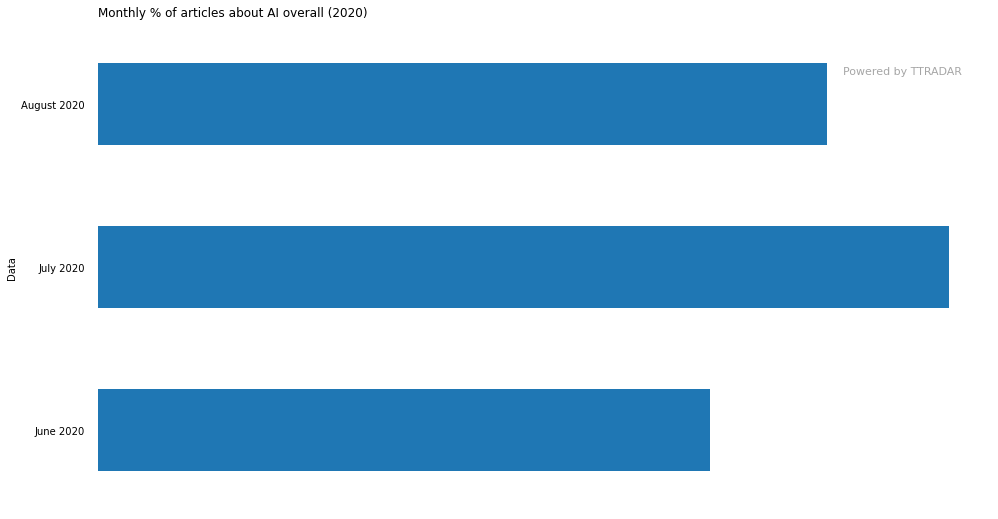

In [29]:
# Figure Size 
fig, ax = plt.subplots(figsize =(16, 9)) 

# Horizontal Bar Plot 
df_monthly.loc[start:end, 'AI'].plot.barh()

ax.set_yticklabels(df_monthly.loc[start:end, 'AI'].index.strftime('%B %Y'))
  
# Remove axes splines 
for s in ['top', 'bottom', 'left', 'right']: 
    ax.spines[s].set_visible(False) 

# Remove x, y Ticks 
ax.xaxis.set_ticks_position('none') 
ax.yaxis.set_ticks_position('none') 
  
# Add padding between axes and labels 
ax.xaxis.set_tick_params(pad = 5) 
ax.yaxis.set_tick_params(pad = 10) 

# Remove x axis value
ax.xaxis.set_visible(False)

# Add Plot Title 
ax.set_title('Monthly % of articles about AI overall (2020)', loc ='left', ) 
  
# Add Text watermark 
ax.text(0.9, 0.9, 'Powered by TTRADAR', 
        fontsize = 11, color ='grey', alpha = 0.7,
        horizontalalignment='center', verticalalignment='center', 
        transform=ax.transAxes)### % of AI Articles overall
  
# Show Plot 
plt.show() 

### 1.1.2 Yearly articles about selected technologies (2014 - 2020)

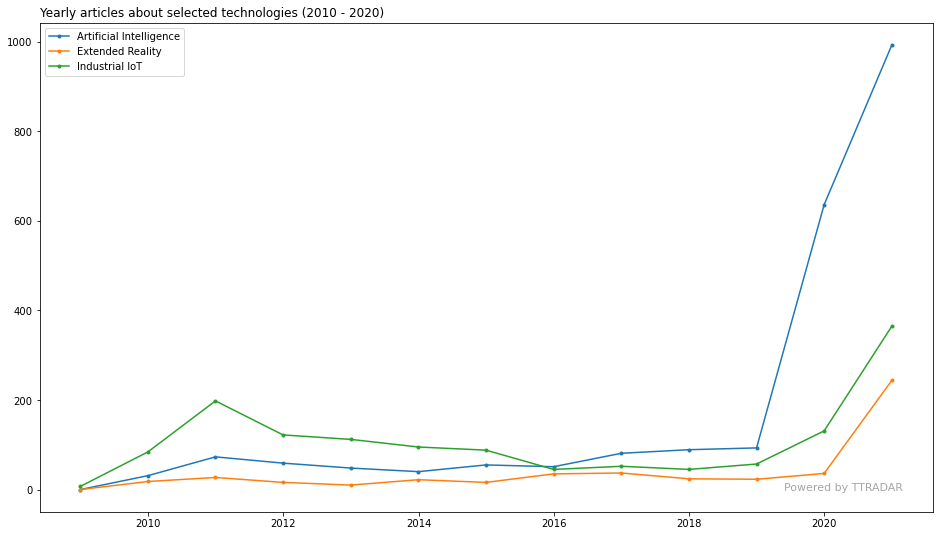

In [30]:
# Figure Size 
fig, ax = plt.subplots(figsize =(16, 9)) 

x = df_yearly.index
y1 = df_yearly['AI']
y2 = df_yearly['AR / VR']
y3 = df_yearly['Industrial IoT']

plt.plot(x,y1,marker='.', label="Artificial Intelligence")
plt.plot(x,y2,marker='.', label='Extended Reality')
plt.plot(x,y3,marker='.', label='Industrial IoT')

# Add Plot Title 
ax.set_title('Yearly articles about selected technologies (2010 - 2020)', loc ='left', ) 
  
# Add Text watermark 
ax.text(0.9, 0.05, 'Powered by TTRADAR', 
        fontsize = 11, color ='grey', alpha = 0.7,
        horizontalalignment='center', verticalalignment='center', 
        transform=ax.transAxes)

plt.legend()

# Show Plot 
plt.show() 

### 1.1.3 Mounthly articles about selected technologies (2010 - 2020)

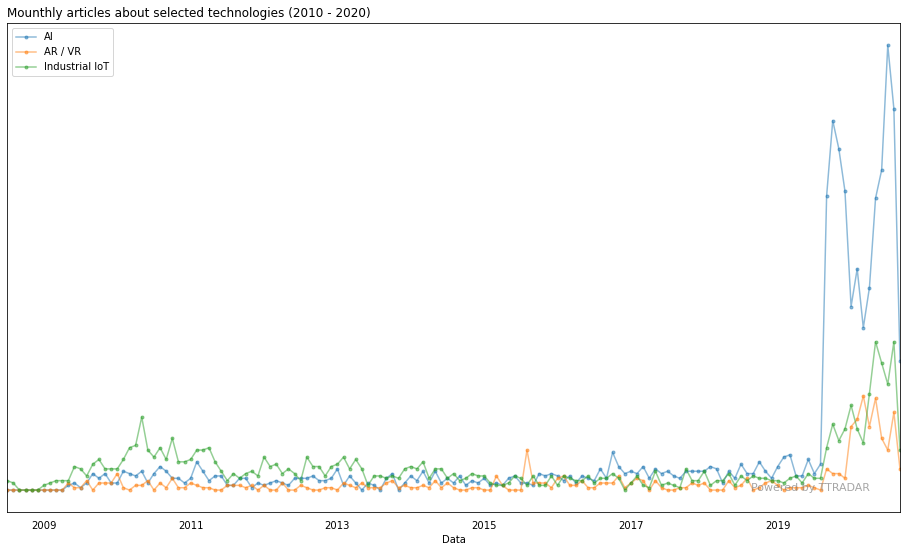

In [31]:
df_x = df_monthly#.loc[start:end]

# Figure Size 
fig, ax = plt.subplots(figsize =(16, 9)) 

df_x['AI'].plot(marker='.', alpha=0.5, linestyle='-', subplots=False)
df_x['AR / VR'].plot(marker='.', alpha=0.5, linestyle='-', subplots=False)
df_x['Industrial IoT'].plot(marker='.', alpha=0.5, linestyle='-', subplots=False)

# Remove x, y Ticks 
ax.xaxis.set_ticks_position('none') 
ax.yaxis.set_ticks_position('none') 
    
# Add padding between axes and labels 
ax.xaxis.set_tick_params(pad = 5) 
ax.yaxis.set_tick_params(pad = 10) 

# Remove y axis value
ax.yaxis.set_visible(False)

plt.legend()

# Add Plot Title 
ax.set_title('Mounthly articles about selected technologies (2010 - 2020)', loc ='left', ) 
  
# Add Text watermark 
ax.text(0.9, 0.05, 'Powered by TTRADAR', 
        fontsize = 11, color ='grey', alpha = 0.7,
        horizontalalignment='center', verticalalignment='center', 
        transform=ax.transAxes)

# Show Plot 
plt.show() 

### 1.1.4 Weekly articles about selected technologies (2020)

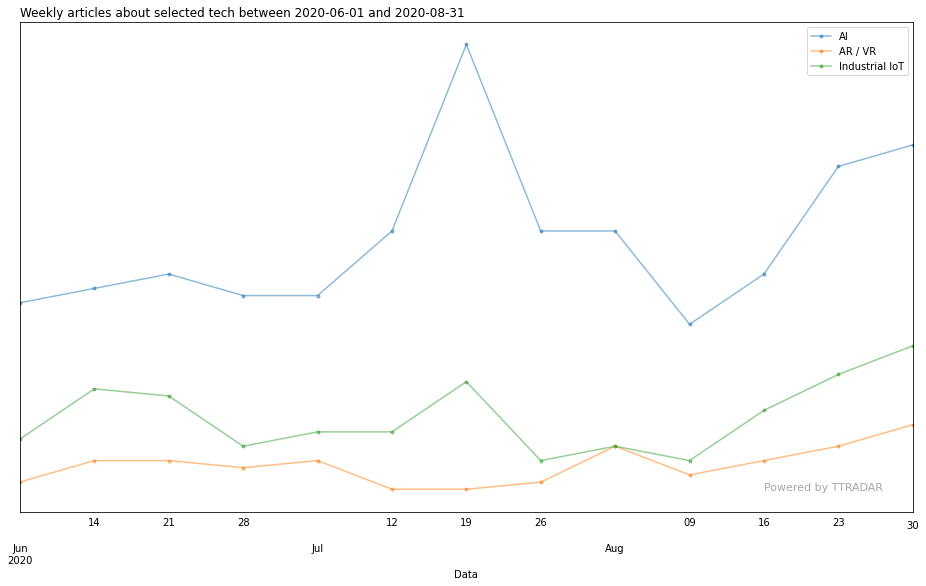

In [32]:
df_x = df_weekly.loc[start:end]

# Figure Size 
fig, ax = plt.subplots(figsize =(16, 9)) 

df_x['AI'].plot(marker='.', alpha=0.5, linestyle='-', subplots=False)
df_x['AR / VR'].plot(marker='.', alpha=0.5, linestyle='-', subplots=False)
df_x['Industrial IoT'].plot(marker='.', alpha=0.5, linestyle='-', subplots=False)

# Remove x, y Ticks 
ax.xaxis.set_ticks_position('none') 
ax.yaxis.set_ticks_position('none') 
    
# Add padding between axes and labels 
ax.xaxis.set_tick_params(pad = 5) 
ax.yaxis.set_tick_params(pad = 10) 

# Remove y axis value
ax.yaxis.set_visible(False)

plt.legend()

# Add Plot Title 
title = "Weekly articles about selected tech between %s and %s" % (start, end)
ax.set_title(title, loc ='left', ) 
  
# Add Text watermark 
ax.text(0.9, 0.05, 'Powered by TTRADAR', 
        fontsize = 11, color ='grey', alpha = 0.7,
        horizontalalignment='center', verticalalignment='center', 
        transform=ax.transAxes)

# Show Plot 
plt.show() 

## 1.2 Subset (Data, Tech, Application)

In [33]:
tech_appl = df_exploded[['Data', 'Tech', 'Application']]
tech_appl = tech_appl[~(tech_appl['Tech'].str.len() == 0)]
tech_appl = tech_appl[~(tech_appl['Application'].str.len() == 0)]
tech_appl = tech_appl.set_index(tech_appl['Data'])

In [34]:
print("Start %s End %s" % (start, end))

Start 2020-06-01 End 2020-08-31


In [35]:
tech_appl.count()

Data           3265
Tech           3265
Application    3265
dtype: int64

In [36]:
tech_appl = tech_appl.loc[start:end]

In [37]:
tech_appl.count()

Data           704
Tech           704
Application    704
dtype: int64

In [38]:
def explode_tech_application(df):
    data_tech = pd.concat([pd.Series(row['Data'], row['Tech'].split(', '))              
           for _, row in df.iterrows()])
    df1 = pd.DataFrame({'Data':data_tech.values, 'Tech':data_tech.index})

    data_appl = pd.concat([pd.Series(row['Data'], row['Application'].split(', '))              
           for _, row in df.iterrows()])

    df2 = pd.DataFrame({'Data':data_appl.values, 'Application':data_appl.index})

    res = pd.merge(df1,df2,on='Data',how='left')
    #res = df2
    res = res.sort_index()
    res = res.reset_index(drop=True)
    
    return res

In [39]:
tech_appl = explode_tech_application(tech_appl)
#tech_appl = df

In [40]:
tech_appl

,Data,Tech,Application
0,2020-06-01,Batteries,Energy Storage
1,2020-06-01,Batteries,Electric Vehicles
2,2020-06-01,Batteries,Contact Tracing
3,2020-06-01,Batteries,Goods Delivery
4,2020-06-01,Batteries,Autonomous Vehicles
...,...,...,...
14072,2020-06-11,Batteries,Cybersecurity
14073,2020-06-11,Batteries,E-Commerce
14074,2020-06-11,Batteries,Computer Vision
14075,2020-06-11,Batteries,Energy Storage


### 1.2.1 Top Applications in timeframe

In [41]:
count_series = tech_appl.groupby(['Application']).size()
applications = count_series.to_frame(name = 'Size').reset_index()
applications = applications.nlargest(10, 'Size')
applications.sort_values(by = 'Size', ascending=False, inplace=True)
applications.head(15)

,Application,Size
22,Energy Storage,1610
30,Mobile Communitations,1367
39,Security,840
25,Goods Delivery,716
3,Autonomous Vehicles,707
0,Advanced Analytics,624
14,Cybersecurity,594
20,Economy,587
41,Sharing Economy,571
38,Renewables,561


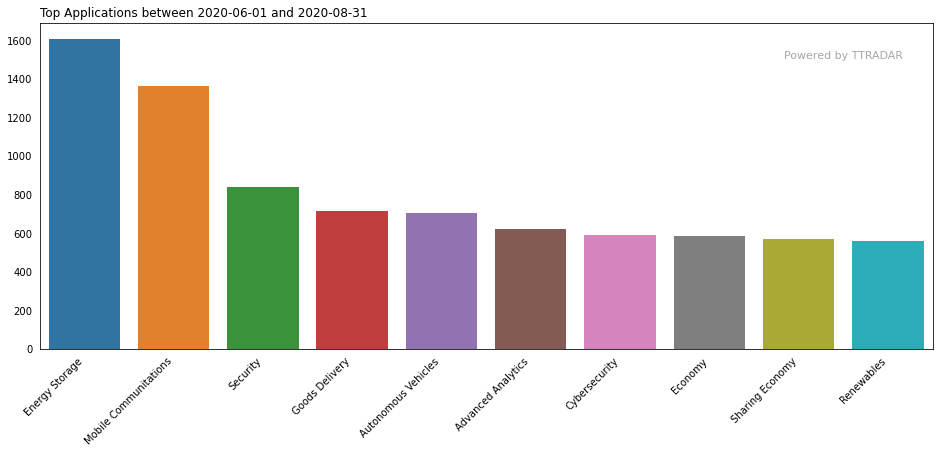

In [42]:
plt.figure(figsize=(16,6))
ax=sns.barplot(x='Application', y='Size', data=applications)

ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.ylabel("Articoli")
plt.xlabel("Applicazione")

# Remove x, y Ticks 
ax.xaxis.set_ticks_position('none') 
ax.yaxis.set_ticks_position('none') 

ax.set_ylabel('')    
ax.set_xlabel('')

# Remove y axis value
#ax.yaxis.set_visible(False)

# Add Plot Title 
title = "Top Applications between %s and %s" % (start, end)
ax.set_title(title, loc ='left') 

ax.text(0.9, 0.9, 'Powered by TTRADAR', 
        fontsize = 11, color ='grey', alpha = 0.7,
        horizontalalignment='center', verticalalignment='center', 
        transform=ax.transAxes)

plt.show()

### 1.2.2 Top applications for selected technology

In [43]:
technology = "Batteries"
#technology = "Autonomous Vehicles"

In [44]:
df_selected_tech = tech_appl.loc[tech_appl['Tech'] == technology]
count_series = df_selected_tech.groupby(['Tech', 'Application']).size()

df_selected_tech = count_series.to_frame(name = 'Size').reset_index()
df_selected_tech = df_selected_tech.nlargest(10, 'Size')
df_selected_tech.sort_values(by = 'Size', ascending=False, inplace=True)
df_selected_tech.head()

,Tech,Application,Size
21,Batteries,Energy Storage,336
29,Batteries,Mobile Communitations,161
38,Batteries,Security,109
37,Batteries,Renewables,105
19,Batteries,Economy,88


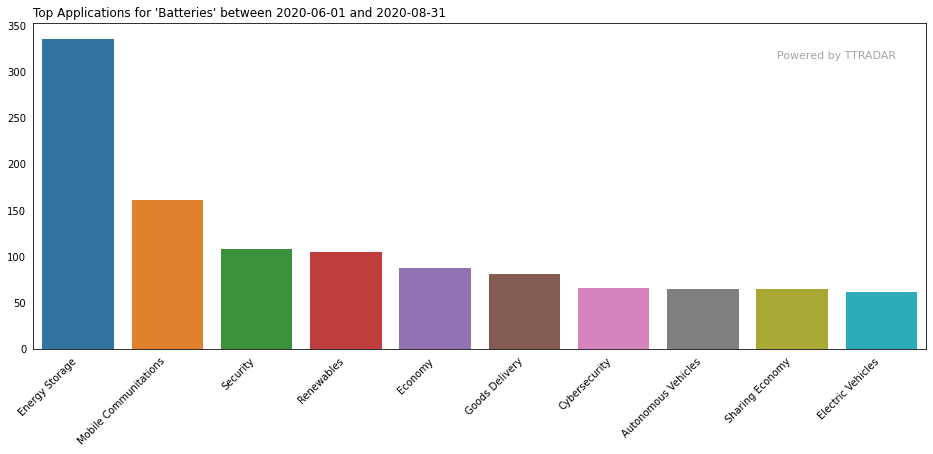

In [45]:
plt.figure(figsize=(16,6))
ax=sns.barplot(x='Application', y='Size', data=df_selected_tech)

ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.ylabel("Articoli")
plt.xlabel("Applicazione")

# Remove x, y Ticks 
ax.xaxis.set_ticks_position('none') 
ax.yaxis.set_ticks_position('none') 

ax.set_ylabel('')    
ax.set_xlabel('')

# Remove y axis value
#ax.yaxis.set_visible(False)

# Add Plot Title 
title = "Top Applications for '%s' between %s and %s" % (technology, start, end)
ax.set_title(title, loc ='left') 

ax.text(0.9, 0.9, 'Powered by TTRADAR', 
        fontsize = 11, color ='grey', alpha = 0.7,
        horizontalalignment='center', verticalalignment='center', 
        transform=ax.transAxes)

plt.show()

### 1.2.3 Top Technologies for selected application

In [46]:
#application = "Autonomous Vehicles"
application = "Energy Storage"

In [47]:
df_selected_application = tech_appl.loc[tech_appl['Application'] == application]
count_series = df_selected_application.groupby(['Tech', 'Application']).size()

df_selected_application = count_series.to_frame(name = 'Size').reset_index()
df_selected_application = df_selected_application.nlargest(10, 'Size')
df_selected_application.sort_values(by = 'Size', ascending=False, inplace=True)
df_selected_application.head()

,Tech,Application,Size
9,Mobile,Energy Storage,472
0,AI,Energy Storage,392
2,Batteries,Energy Storage,336
8,Industrial IoT,Energy Storage,154
7,Connectivity,Energy Storage,96


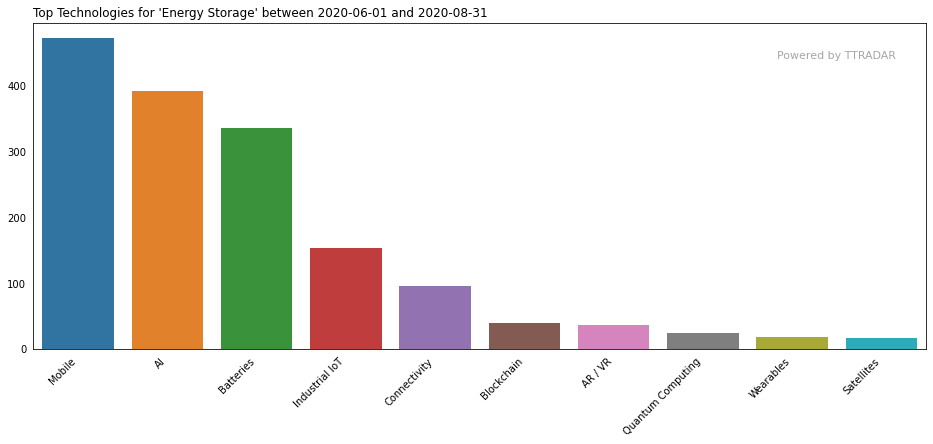

In [48]:
plt.figure(figsize=(16,6))
ax=sns.barplot(x='Tech', y='Size', data=df_selected_application)

ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.ylabel("Articoli")
plt.xlabel("Applicazione")

# Remove x, y Ticks 
ax.xaxis.set_ticks_position('none') 
ax.yaxis.set_ticks_position('none') 

ax.set_ylabel('')    
ax.set_xlabel('')

# Remove y axis value
#ax.yaxis.set_visible(False)

# Add Plot Title 
title = "Top Technologies for '%s' between %s and %s" % (application, start, end)
ax.set_title(title, loc ='left') 

ax.text(0.9, 0.9, 'Powered by TTRADAR', 
        fontsize = 11, color ='grey', alpha = 0.7,
        horizontalalignment='center', verticalalignment='center', 
        transform=ax.transAxes)

plt.show()

### 1.2.5 Weekly articles about energy related applications (2020)

In [49]:
df_applications = tech_appl

In [50]:
for c in df_applications['Application'].unique():
    df_applications[c] = df_applications['Application'].apply(lambda x: expand_column(x, c))

In [51]:
df_applications = df_applications.set_index(df_applications['Data'])
df_applications = df_applications.resample('W').sum()

C:\Users\edoardo.esposito\AppData\Local\Continuum\anaconda3\envs\techadv\lib\site-packages\ipykernel_launcher.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator


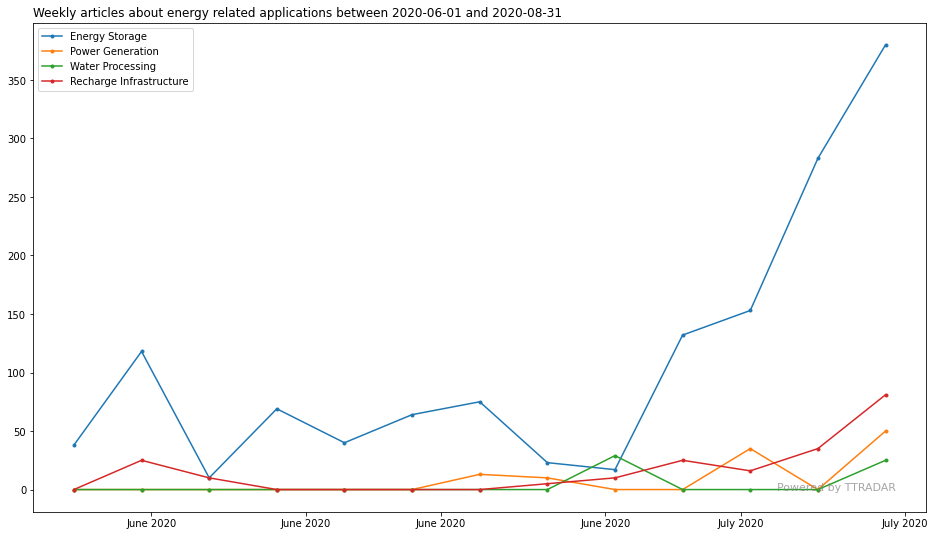

In [52]:
df_x = df_applications.loc[start:end]

# Figure Size 
fig, ax = plt.subplots(figsize =(16, 9)) 

x = df_x.index
y1 = df_x.loc[start:end, 'Energy Storage']
y2 = df_x.loc[start:end, 'Power Generation']
y3 = df_x.loc[start:end, 'Water Processing']
y4 = df_x.loc[start:end, 'Recharge Infrastructure']

plt.plot(x,y1,marker='.', label="Energy Storage")
plt.plot(x,y2,marker='.', label='Power Generation')
plt.plot(x,y3,marker='.', label='Water Processing')
plt.plot(x,y4,marker='.', label='Recharge Infrastructure')

ax.set_xticklabels(df_x.index.strftime('%B %Y'))

# Add Plot Title 
title = "Weekly articles about energy related applications between %s and %s" % (start, end)
ax.set_title(title, loc ='left', ) 
  
# Add Text watermark 
ax.text(0.9, 0.05, 'Powered by TTRADAR', 
        fontsize = 11, color ='grey', alpha = 0.7,
        horizontalalignment='center', verticalalignment='center', 
        transform=ax.transAxes)

plt.legend()

# Show Plot 
plt.show() 

### 1.2.6 Technologies related to each Application

In [53]:
df_vertical_tech = tech_appl[['Tech', 'Application']]
df_vertical_tech['Value'] = 1

C:\Users\edoardo.esposito\AppData\Local\Continuum\anaconda3\envs\techadv\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [54]:
df_vertical_tech

,Tech,Application,Value
0,Batteries,Energy Storage,1
1,Batteries,Electric Vehicles,1
2,Batteries,Contact Tracing,1
3,Batteries,Goods Delivery,1
4,Batteries,Autonomous Vehicles,1
...,...,...,...
14072,Batteries,Cybersecurity,1
14073,Batteries,E-Commerce,1
14074,Batteries,Computer Vision,1
14075,Batteries,Energy Storage,1


In [55]:
df_vertical_tech_pivot = pd.pivot_table(df_vertical_tech, 
                                        values=["Value"], 
                                        index=["Tech"], 
                                        columns=["Application"], 
                                        fill_value=0, 
                                        aggfunc='count', 
                                        margins=False) 

In [56]:
df_vertical_tech_pivot

Value                     \
Application               Advanced Analytics Antispam Astronomy   
Tech                                                              
AI                                       212       24         4   
AR / VR                                   14        2         0   
Batteries                                 61       10         2   
Big Data                                   5        0         0   
Biometrics                                 9        1         0   
Blockchain                                14        3         1   
Brain Computer Interfaces                  9        0         0   
Connectivity                              70       11         4   
Industrial IoT                            60        9         2   
Mobile                                   146       18         2   
Quantum Computing                          6        0         0   
Satellites                                11        1         1   
Wearables                                  7        2         0   

                                                                    \
Application               Autonomous Vehicles Behavioural Sciences   
Tech                                                                 
AI                                        279                   45   
AR / VR                                    11                    4   
Batteries                                  65                   22   
Big Data                                    1                    0   
Biometrics                                  7                    0   
Blockchain                                 33                    2   
Brain Computer Interfaces                   9                    0   
Connectivity                               47                    8   
Industrial IoT                             62                   16   
Mobile                                    166                   46   
Quantum Computing                           7                    5   
Satellites                                 13                    2   
Wearables                                   7                    1   

                                                                   \
Application               Bio Engineering Chatbot Computer Vision   
Tech                                                                
AI                                    100      57              94   
AR / VR                                 6       4               3   
Batteries                              28       6              21   
Big Data                                4       0               0   
Biometrics                              1       1               3   
Blockchain                              6       5               7   
Brain Computer Interfaces               6       1               2   
Connectivity                           25       7              24   
Industrial IoT                         25      17              23   
Mobile                                 66      37              46   
Quantum Computing                       5       0               3   
Satellites                              5       3               1   
Wearables                               0       0               4   

                                                        ...             \
Application               Contact Tracing Crowdfunding  ... Smart Home   
Tech                                                    ...              
AI                                     68           27  ...          6   
AR / VR                                 7            0  ...          2   
Batteries                              31            3  ...          4   
Big Data                                2            0  ...          0   
Biometrics                              2            1  ...          1   
Blockchain                             12            3  ...          1   
Brain Computer Interfaces               2            1  ...          0   


Text(0.5, 1.0, 'Technologies related to each Application')

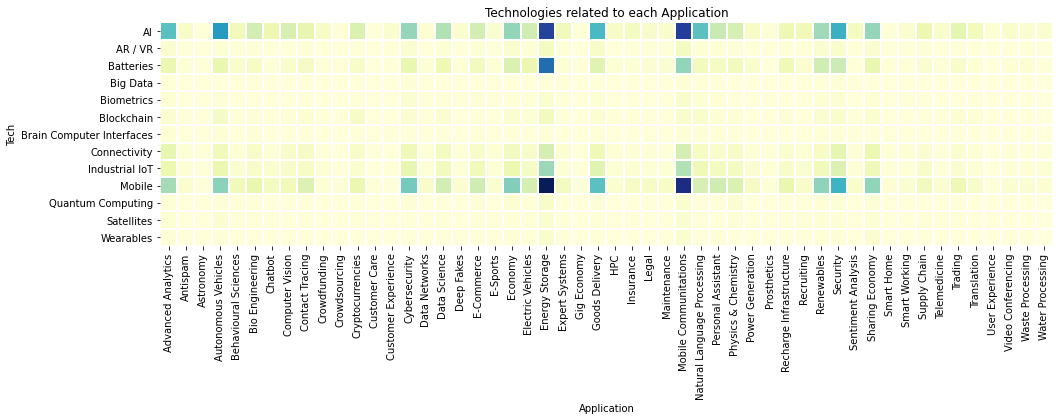

In [57]:
plt.figure(figsize=(16,16))
sns.heatmap(df_vertical_tech_pivot['Value'],
            linewidths=1, 
            annot=False ,
            vmin=0.01,
            cmap='YlGnBu', 
            cbar=False, square=True)
plt.title('Technologies related to each Application')

In [58]:
tech_appl

,Data,Tech,Application,Energy Storage,Electric Vehicles,Contact Tracing,Goods Delivery,Autonomous Vehicles,Data Science,Natural Language Processing,...,Antispam,E-Sports,User Experience,Power Generation,Maintenance,Customer Care,Water Processing,Video Conferencing,Crowdsourcing,Gig Economy
0,2020-06-01,Batteries,Energy Storage,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2020-06-01,Batteries,Electric Vehicles,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2020-06-01,Batteries,Contact Tracing,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2020-06-01,Batteries,Goods Delivery,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2020-06-01,Batteries,Autonomous Vehicles,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14072,2020-06-11,Batteries,Cybersecurity,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
14073,2020-06-11,Batteries,E-Commerce,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
14074,2020-06-11,Batteries,Computer Vision,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
14075,2020-06-11,Batteries,Energy Storage,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [59]:
dd=pd.get_dummies(tech_appl['Tech'])

list = []
for i in tech_appl['Tech'].unique():
    list.append(dd[i].sum())

[Text(0.5, 0, 'Number of tech')]

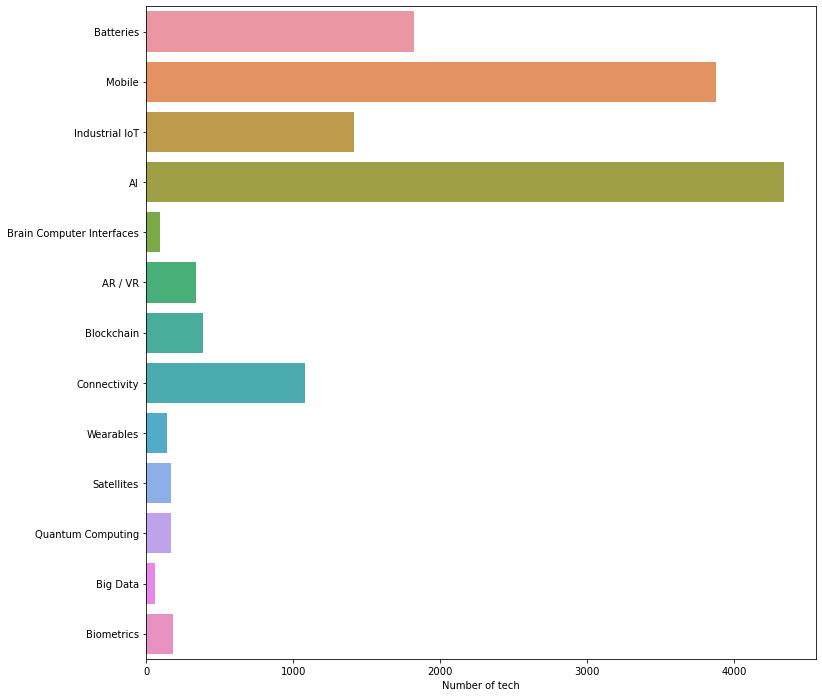

In [60]:
plt.figure(figsize=(12, 12))
ax=sns.barplot(y=tech_appl['Tech'].unique(),x=list,data=tech_appl)
ax.set(xlabel='Number of tech')

In [61]:
tech_appl['Application'].replace("", float('NaN'), inplace=True)
data = tech_appl.dropna(subset = ["Application"])
data = data[data.groupby('Application').Application.transform('count')>100].copy() 

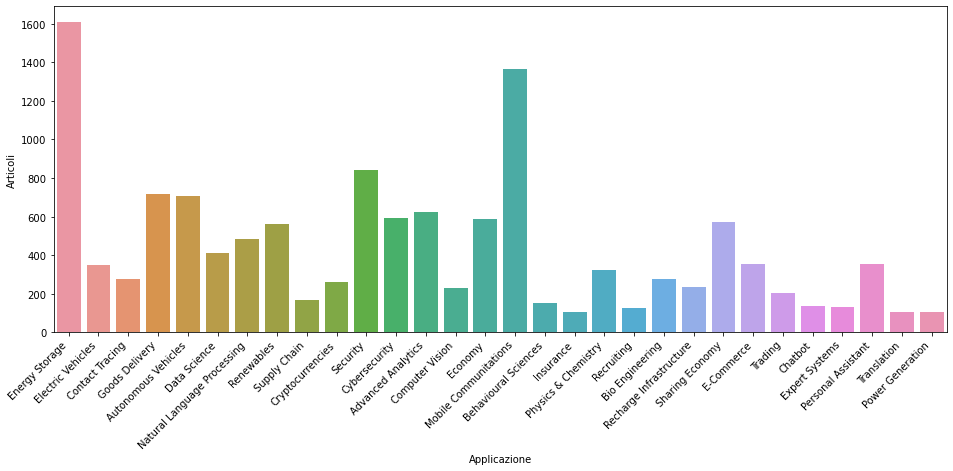

In [62]:
plt.figure(figsize=(16,6))
ax=sns.countplot(data['Application'])
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.ylabel("Articoli")
plt.xlabel("Applicazione")
plt.show()